In [2]:
!which python 
!whoami 
!hostname
!pwd

/home/farshed.abdukhakimov/miniconda3/envs/main/bin/python
farshed.abdukhakimov
srv-01
/home/farshed.abdukhakimov/projects/root-newton


In [3]:
%load_ext autoreload
%autoreload 2

import datetime
from collections import defaultdict

import numpy as np
import scipy

from dotenv import load_dotenv
load_dotenv()

import utils
from losses import BaseOracle, LogisticRegressionLoss
from methods import *

In [4]:
def train_loop(w_0: float, dataset_name: str, n_steps: int,
               optimizer: BaseOptimizer, **optimizer_kwargs) -> dict: 
    
    np.random.seed(0)
    
    # dataset
    if dataset_name == "synthetic":
        train_data, train_target = utils.make_synthetic_binary_classification(1000, 100)
    else:
        train_data, train_target = utils.get_LIBSVM(dataset_name)
        from sklearn.preprocessing import normalize
        train_data = normalize(train_data, norm="l2", axis=1)
        
    
    # parameters
    w = np.full((train_data.shape[1]), fill_value=w_0)
    optim = optimizer(params=w, **optimizer_kwargs)

    # oracle 
    loss_function = LogisticRegressionLoss(train_data, train_target, lmd=1e-3)
    
    # e.g. libsvm dataset has {0.0, 1.0} classes that cannot be used for LogisticRegressionLoss 
    # hence they will be remapped to {-1.0, 1.0}
    if isinstance(loss_function, LogisticRegressionLoss):
        train_target = utils.map_classes_to(train_target, [-1.0, 1.0])
    
    # logging 
    history = defaultdict(list)
    
    start_timestamp = datetime.datetime.now()
        
    for step in range(n_steps):

        time = (datetime.datetime.now() - start_timestamp).total_seconds()
        loss = loss_function.func(w)
        grad = loss_function.grad(w)        
        
        acc = (np.sign(train_data @ w) == train_target).sum() / train_target.shape[0]
        
        optim.step(oracle=loss_function)
        
        # print(f"Step: [{step}/{n_steps}] Loss: {loss} | GradNorm^2: {(np.linalg.norm(grad) ** 2 )} | Acc: {acc}")
        history["loss"].append(loss)
        history["grad_norm"].append(np.linalg.norm(grad) ** 2)
        history["accuracy"].append(acc)
        history["time"].append(time)
    
    return history

In [5]:
hyperparams = {
    "a1a": {
        "DampedNewton": {"lr": 0.25},
        "AICN": {"L_est": 0.1},
        "RootNewton": {"q": 3.5, "L_est": 0.01},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
        "GradRegNewton": {"q": 2.0, "L_est": 1e-5}
    }, 
    "a5a": {
        "DampedNewton": {"lr": 1.0},
        "AICN": {"L_est": 0.1},
        "RootNewton": {"q": 2.0, "L_est": 0.001},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
    }
}

hyperparams_reg = {
    "a1a": {
        "DampedNewton": {"lr": 0.25},
        "AICN": {"L_est": 0.55},
        "RootNewton": {"q": 3.5, "L_est": 0.01},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
        "GradRegNewton": {"q": 2.0, "L_est": 0.001}
    }, 
    "mushrooms": {
        "DampedNewton": {"lr": 0.9},
        "AICN": {"L_est": 0.1},
        "RootNewton": {"q": 3.25, "L_est": 0.0001},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
        "GradRegNewton": {"q": 2.0, "L_est": 0.00001},
    },
    "colon-cancer": {
        "DampedNewton": {"lr": 0.65},
        "AICN": {"L_est": 1.0},
        "RootNewton": {"q": 4.0, "L_est": 0.001},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
        "GradRegNewton": {"q": 2.25, "L_est": 0.0001},
    },
    "w7a": {
        "DampedNewton": {"lr": 0.5},
        "AICN": {"L_est": 0.01},
        "RootNewton": {"q": 3.0, "L_est": 0.01},
        "SimpliReg": {"beta": 0.1, "sigma": 0.1},
        "GradRegNewton": {"q": 2.0, "L_est": 0.0001},
    }
}

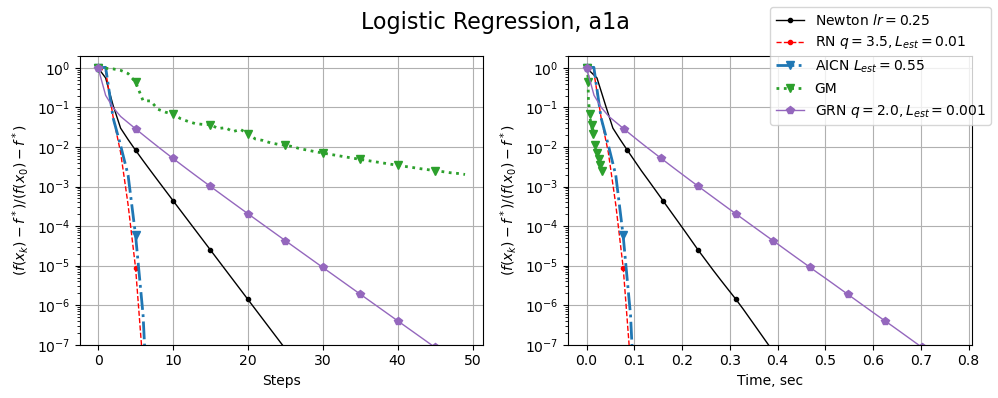

In [8]:
np.random.seed(0)

dataset_name = "a1a"

n_steps = 50

histories = []
labels = []

w_0 = 10.0

# Newton
lr = hyperparams_reg[dataset_name]["DampedNewton"]["lr"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=2*n_steps, optimizer=DampedNewton, lr=lr)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton $lr={0}$".format(lr))


# Root Newton
L_est = hyperparams_reg[dataset_name]["RootNewton"]["L_est"]
q = hyperparams_reg[dataset_name]["RootNewton"]["q"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=RootNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"RN $q={0}, L_{{est}}={1}$".format(q, L_est))

# AICN
L_est = hyperparams_reg[dataset_name]["AICN"]["L_est"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=AICN, L_est=L_est)
histories.append(hist)
labels.append(r"AICN $L_{{est}}={0}$".format(L_est))

# Gradient Method 
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GradientMethod)
histories.append(hist)
labels.append("GM")

# GradRegNewton
q = hyperparams_reg[dataset_name]["GradRegNewton"]["q"]
L_est = hyperparams_reg[dataset_name]["GradRegNewton"]["L_est"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GradRegNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"GRN $q={0}, L_{{est}}={1}$".format(q, L_est))


utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "v", "p"],
        f_star=f_star, 
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=1e-7,
        filename=f"plots/logreg_rn_{dataset_name}.pdf")

In [ ]:
np.random.seed(0)

dataset_name = "mushrooms"

n_steps = 50

w_0 = 10.0

histories = []
labels = []

# Newton
lr = hyperparams_reg[dataset_name]["DampedNewton"]["lr"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=2*n_steps, optimizer=DampedNewton, lr=lr)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton $lr={0}$".format(lr))

# Root Newton
L_est = hyperparams_reg[dataset_name]["RootNewton"]["L_est"]
q = hyperparams_reg[dataset_name]["RootNewton"]["q"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=RootNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"RN $q={0}, L_{{est}}={1}$".format(q, L_est))

# AICN
L_est = hyperparams_reg[dataset_name]["AICN"]["L_est"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=AICN, L_est=L_est)
histories.append(hist)
labels.append(r"AICN $L_{{est}}={0}$".format(L_est))

# Gradient Method 
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GradientMethod)
histories.append(hist)
labels.append("GM")

# GradRegNewton
q = hyperparams_reg[dataset_name]["GradRegNewton"]["q"]
L_est = hyperparams_reg[dataset_name]["GradRegNewton"]["L_est"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GradRegNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"GRN $q={0}, L_{{est}}={1}$".format(q, L_est))

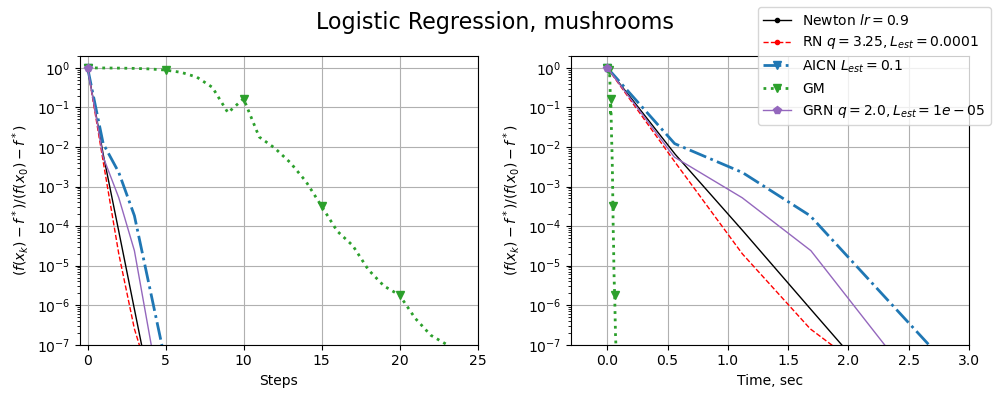

In [26]:
utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "v", "p"],
        f_star=f_star, 
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=1e-7,
        xlims=(25, 3),
        filename=f"plots/logreg_rn_{dataset_name}.pdf")

In [6]:
np.random.seed(0)

dataset_name = "colon-cancer"

n_steps = 50

histories = []
labels = []

w_0 = 10.0

# Newton
lr = hyperparams_reg[dataset_name]["DampedNewton"]["lr"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=2*n_steps, optimizer=DampedNewton, lr=lr)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton $lr={0}$".format(lr))

# Root Newton
L_est = hyperparams_reg[dataset_name]["RootNewton"]["L_est"]
q = hyperparams_reg[dataset_name]["RootNewton"]["q"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=RootNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"RN $q={0}, L_{{est}}={1}$".format(q, L_est))

# AICN
L_est = hyperparams_reg[dataset_name]["AICN"]["L_est"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=AICN, L_est=L_est)
histories.append(hist)
labels.append(r"AICN $L_{{est}}={0}$".format(L_est))

# Gradient Method 
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GradientMethod)
histories.append(hist)
labels.append("GM")

# GradRegNewton
q = hyperparams_reg[dataset_name]["GradRegNewton"]["q"]
L_est = hyperparams_reg[dataset_name]["GradRegNewton"]["L_est"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GradRegNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"GRN $q={0}, L_{{est}}={1}$".format(q, L_est))

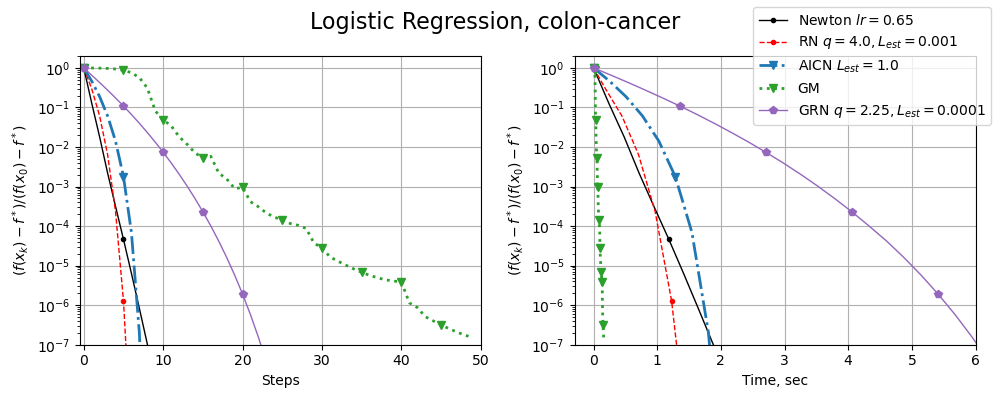

In [7]:
utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "v", "p"],
        f_star=f_star, 
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=1e-7,
        xlims=(50, 6),
        filename=f"plots/logreg_rn_{dataset_name}.pdf")

In [8]:
np.random.seed(0)

dataset_name = "w7a"

n_steps = 30

histories = []
labels = []

w_0 = 10.0

# Newton
lr = hyperparams_reg[dataset_name]["DampedNewton"]["lr"]
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=2*n_steps, optimizer=DampedNewton, lr=lr)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton $lr={0}$".format(lr))

# Root Newton
L_est = 0.01
q = 3.0
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=RootNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"RN $q={0}, L_{{est}}={1}$".format(q, L_est))

# AICN
L_est = 0.01
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=AICN, L_est=L_est)
histories.append(hist)
labels.append(r"AICN $L_{{est}}={0}$".format(L_est))

# Gradient Method 
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GradientMethod)
histories.append(hist)
labels.append("GM")

# GradRegNewton
q = 2.0
L_est = 0.00001
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=GradRegNewton, q=q, L_est=L_est)
histories.append(hist)
labels.append(r"GRN $q={0}, L_{{est}}={1}$".format(q, L_est))

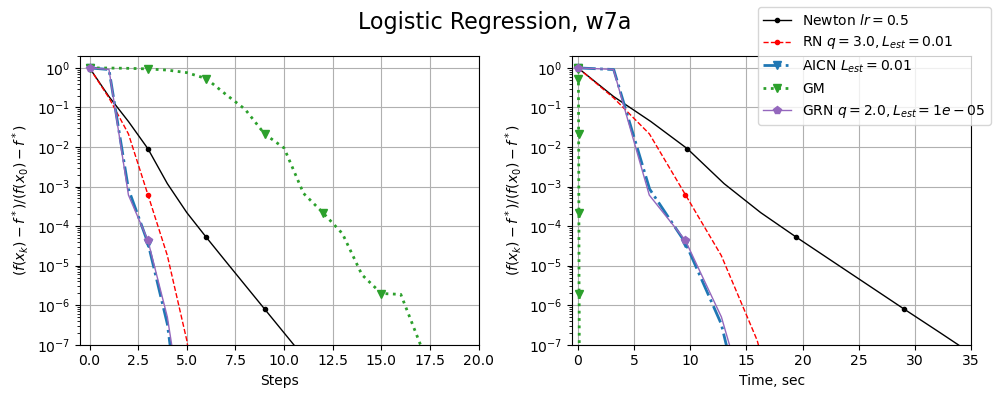

In [12]:
utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "v", "p"],
        f_star=f_star, 
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=1e-7,
        xlims=(20, 35),
        filename=f"plots/logreg_rn_{dataset_name}.pdf")

In [15]:
np.random.seed(0)

dataset_name = "a1a"

n_steps = 30

histories = []
labels = []

w_0 = 10.0

# Newton
lr = 0.25
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=2*n_steps, optimizer=DampedNewton, lr=lr)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton $lr={0}$".format(lr))


# Super Newton
for alpha, ls, color, l in zip([2/3, 1.0], ["-", "-."], ["black", "red"], ["2/3", "1"]):    
    hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=SuperNewton, alpha=alpha)
    histories.append(hist)
    labels.append(r"Super-Univ, ${0}$".format(l))

# Universal Newton
sigma_0 = 1.0
c = 2.0
for beta, ls, l in zip([2/3, 1.0], ["-", ":"], ["2/3", "1"]):
    hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=UniversalNewton, beta=beta, sigma_0=sigma_0, c=c)
    histories.append(hist)
    labels.append(r"Univ-Newton, ${0}$".format(l))

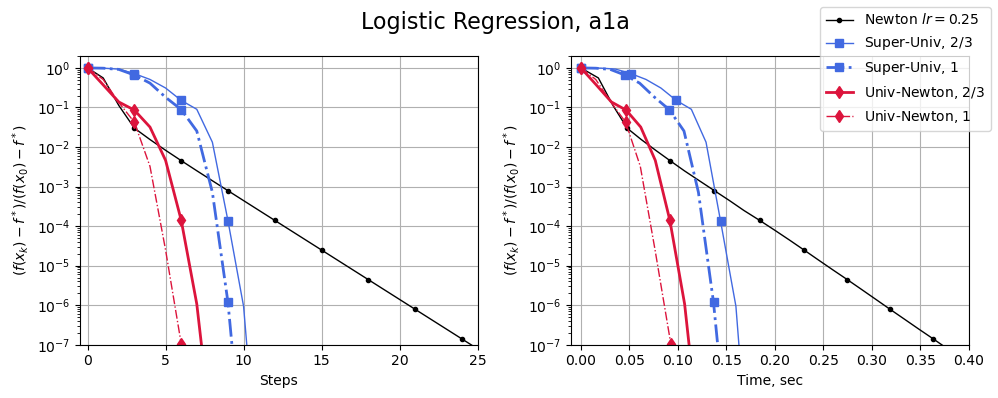

In [27]:
utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "royalblue", "royalblue", "crimson", "crimson", "saddlebrown"],
        linestyles=["-", "-", "-.", "-", "-.", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0],
        markers=[".", "s", "s", "d", "d", "p"],
        f_star=f_star,
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=1e-7,
        xlims=((-0.5, 25), (-0.01, 0.4)),
        filename=f"plots/logreg_univ_{dataset_name}.pdf")

In [28]:
np.random.seed(0)

dataset_name = "mushrooms"

n_steps = 30

histories = []
labels = []

w_0 = 10.0

# Newton
lr = 0.9
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=2*n_steps, optimizer=DampedNewton, lr=lr)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton $lr={0}$".format(lr))

# Super Newton
for alpha, ls, color, l in zip([2/3, 1.0], ["-", "-."], ["black", "red"], ["2/3", "1"]):    
    hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=SuperNewton, alpha=alpha)
    histories.append(hist)
    labels.append(r"Super-Univ, ${0}$".format(l))

# Universal Newton
sigma_0 = 1.0
c = 2.0
for beta, ls, l in zip([2/3, 1.0], ["-", ":"], ["2/3", "1"]):
    hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=UniversalNewton, beta=beta, sigma_0=sigma_0, c=c)
    histories.append(hist)
    labels.append(r"Univ-Newton, ${0}$".format(l))

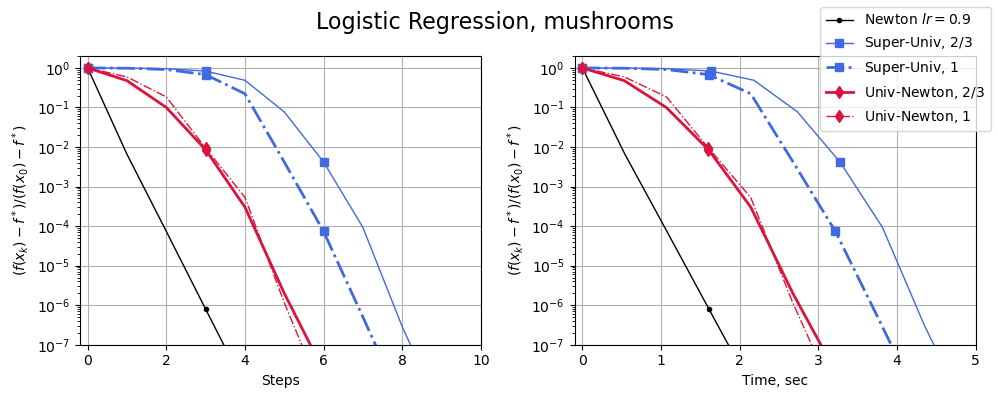

In [31]:
utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "royalblue", "royalblue", "crimson", "crimson", "saddlebrown"],
        linestyles=["-", "-", "-.", "-", "-.", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0],
        markers=[".", "s", "s", "d", "d", "p"],
        f_star=f_star,
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=1e-7,
        xlims=((-0.2, 10), (-0.1, 5)),
        filename=f"plots/logreg_univ_{dataset_name}.pdf")

In [32]:
np.random.seed(0)

dataset_name = "colon-cancer"

n_steps = 30

histories = []
labels = []

w_0 = 10.0

# Newton
lr = 0.65
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=2*n_steps, optimizer=DampedNewton, lr=lr)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton $lr={0}$".format(lr))

# Super Newton
for alpha, ls, color, l in zip([2/3, 1.0], ["-", "-."], ["black", "red"], ["2/3", "1"]):    
    hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=SuperNewton, alpha=alpha)
    histories.append(hist)
    labels.append(r"Super-Univ, ${0}$".format(l))

# Universal Newton
sigma_0 = 1.0
c = 2.0
for beta, ls, l in zip([2/3, 1.0], ["-", ":"], ["2/3", "1"]):
    hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=UniversalNewton, beta=beta, sigma_0=sigma_0, c=c)
    histories.append(hist)
    labels.append(r"Univ-Newton, ${0}$".format(l))


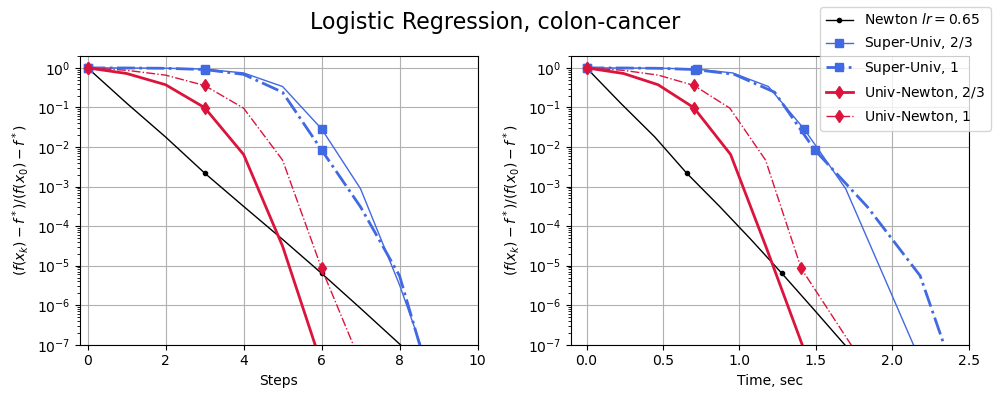

In [36]:
utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "royalblue", "royalblue", "crimson", "crimson", "saddlebrown"],
        linestyles=["-", "-", "-.", "-", "-.", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0],
        markers=[".", "s", "s", "d", "d", "p"],
        f_star=f_star,
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=1e-7,
        xlims=((-0.2, 10), (-0.1, 2.5)),
        filename=f"plots/logreg_univ_{dataset_name}.pdf")

In [37]:
np.random.seed(0)

dataset_name = "w7a"

n_steps = 50

histories = []
labels = []

w_0 = 10.0

# Newton
lr = 0.5
hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=2*n_steps, optimizer=DampedNewton, lr=lr)
f_star = hist["loss"][-1]
hist = {key: value[:n_steps] for key, value in hist.items()}
histories.append(hist)
labels.append(r"Newton $lr={0}$".format(lr))

# Super Newton
for alpha, ls, color, l in zip([2/3, 1.0], ["-", "-."], ["black", "red"], ["2/3", "1"]):    
    hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=SuperNewton, alpha=alpha)
    histories.append(hist)
    labels.append(r"Super-Univ, ${0}$".format(l))

# Universal Newton
sigma_0 = 1.0
c = 2.0
for beta, ls, l in zip([2/3, 1.0], ["-", ":"], ["2/3", "1"]):
    hist = train_loop(w_0=w_0, dataset_name=dataset_name, n_steps=n_steps, optimizer=UniversalNewton, beta=beta, sigma_0=sigma_0, c=c)
    histories.append(hist)
    labels.append(r"Univ-Newton, ${0}$".format(l))


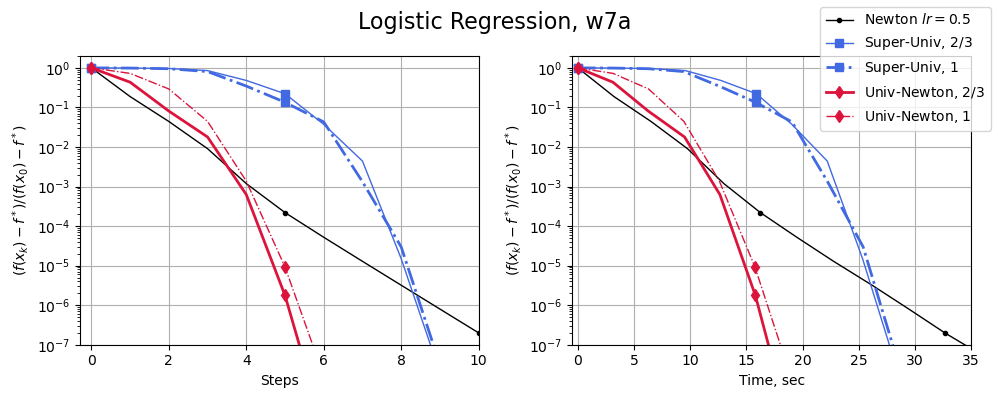

In [46]:
utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "royalblue", "royalblue", "crimson", "crimson", "saddlebrown"],
        linestyles=["-", "-", "-.", "-", "-.", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0, 1.0],
        markers=[".", "s", "s", "d", "d", "p"],
        f_star=f_star,
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=1e-7,
        xlims=((-0.3, 10), (-0.5, 35)),
        filename=f"plots/logreg_univ_{dataset_name}.pdf")

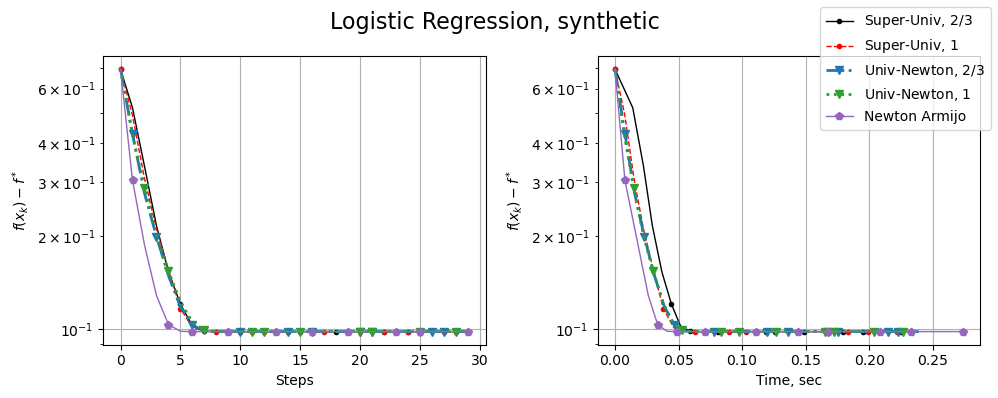

In [12]:
np.random.seed(0)

dataset_name = "synthetic"

n_steps = 30

histories = []
labels = []


# Super Newton
for alpha, ls, color, l in zip([2/3, 1.0], ["-", "-."], ["black", "red"], ["2/3", "1"]):    
    hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=SuperNewton, alpha=alpha)
    histories.append(hist)
    labels.append(r"Super-Univ, ${0}$".format(l))

# Universal Newton
sigma_0 = 1.0
c = 2.0
for beta, ls, l in zip([2/3, 1.0], ["-", ":"], ["2/3", "1"]):
    hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=UniversalNewton, beta=beta, sigma_0=sigma_0, c=c)
    histories.append(hist)
    labels.append(r"Univ-Newton, ${0}$".format(l))
    
# Universal Newton Armijo 
hist = train_loop(dataset_name=dataset_name, n_steps=n_steps, optimizer=ArmijoNewton, gamma=1.0, tau=0.01)
histories.append(hist)
labels.append(r"Newton Armijo")


utils.plotter(histories=histories, 
        labels=labels,
        colors=["black", "red", "tab:blue", "tab:green", "tab:purple"],
        linestyles=["-", "--", "-.", ":", "-"],
        linewidths=[1.0, 1.0, 2.0, 2.0, 1.0],
        markers=[".", ".", "v", "v", "p"], 
        f_star=0.0,
        suptitle=f"Logistic Regression, {dataset_name}",
        threshold=0.0)